## Echo top height detection algorithm and comparison vs VISST

This notebook detects echo top heights in regions covered by DCCs. 
It will look at the maximum height where Z > 1 dBZ.

In [129]:
import pyart
from matplotlib import pyplot as plt
%matplotlib inline
from copy import deepcopy
import numpy as np
import math
from mpl_toolkits.basemap import Basemap
from scipy import ndimage, interpolate
from netCDF4 import Dataset
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import datetime

In [130]:
multidop_grid = '/home/rjackson/multidop_grids/cf_compliant_grid200601211920.nc'
sounding = '/home/rjackson/data/soundings/twpsondewnpnC3.b1.20060121.111600.custom.cdf'
visst_image = '/home/rjackson/data/visst/twpvisstpx04m1rv1minnisX30.c1.20060121.000000.custom.cdf'
num_levels = 40

In [131]:
# Get beam crossing angle between radars
def get_bca(grid):
    berr_origin = [-12960.1,-23091.1]
    x,y = np.meshgrid(grid.x['data'], grid.y['data'])
    a = np.sqrt(np.multiply(x,x)+np.multiply(y,y))
    b = np.sqrt(pow(x-berr_origin[0],2)+pow(y-berr_origin[1],2))
    c = np.sqrt(berr_origin[0]*berr_origin[0]+berr_origin[1]*berr_origin[1])
    theta_1 = np.arccos(x/a)
    theta_2 = np.arccos((x-berr_origin[1])/b)
    return np.arccos((a*a+b*b-c*c)/(2*a*b))

def dms_to_decimal(deg, minutes, seconds):
    return deg+minutes/60+seconds/3600

# Convert seconds to midnight to a string format
def seconds_to_midnight_to_string(time_secs_after_midnight):

    hours = math.floor(time_secs_after_midnight/3600)
    minutes = math.floor((time_secs_after_midnight - hours*3600)/60)
    temp = datetime.time(int(hours), int(minutes), )
    return temp.strftime('%H%M%S')

def seconds_to_midnight_to_hm(time_secs_after_midnight):
    hours = math.floor(time_secs_after_midnight/3600)
    minutes = math.floor((time_secs_after_midnight - hours*3600)/60)
    return hours, minutes


In [132]:
pyart_grid = pyart.io.read_grid(multidop_grid)
bca = get_bca(pyart_grid)
w = pyart_grid.fields['upward_air_velocity']['data']
z = pyart_grid.fields['reflectivity']['data']
bca = np.ma.masked_invalid(bca)

for levels in range(0,num_levels-1):
    w_outside_updraft = np.logical_or(w[levels] < 1, w[levels] > 99.0)
    outside_dd_lobes = np.logical_or(bca < math.pi/6, bca > 5*math.pi/6)
    w[levels] = np.ma.masked_where(np.logical_or(w_outside_updraft,
                                                 outside_dd_lobes), w[levels])
    z[levels] = np.ma.masked_where(np.logical_or(w_outside_updraft,
                                                 outside_dd_lobes), z[levels])


grid_z = pyart_grid.point_z['data']

/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in arccos
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in less
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in greater


In [133]:
Sounding_netcdf = Dataset(sounding, mode='r')
Time = Sounding_netcdf.variables['time_offset'][:]
base_time = Sounding_netcdf.variables['base_time'][:]
alt = Sounding_netcdf.variables['alt'][:]
temp = Sounding_netcdf.variables['tdry'][:]

Tz = interpolate.interp1d(alt, temp+273.15)
grid_temp = Tz(grid_z)

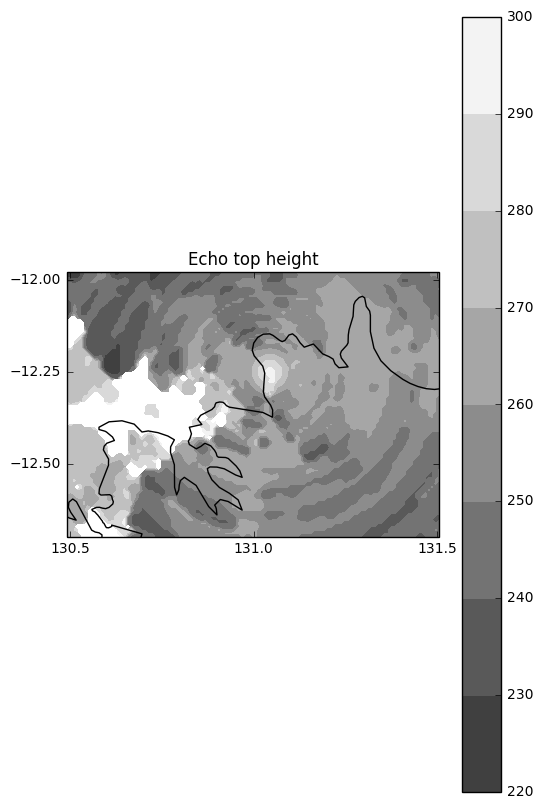

In [134]:
# Set mask to exclude data outside of updrafts
w_temp = deepcopy(w)
w_temp[~w_temp.mask] = 1
w_temp[w_temp.mask] = 0
w_temp.mask = False
array_shape = w_temp.shape
six_connected_structure = [[[0,0,0],
                            [0,1,0],
                            [0,0,0]],
                           [[0,1,0],
                            [1,1,1],
                            [0,1,0]],
                           [[0,0,0],
                            [0,1,0],
                            [0,0,0]]]
updrafts, num_updrafts = ndimage.measurements.label(w_temp, 
                                                    structure=six_connected_structure)

# Get statistics in continous regions
index=np.arange(0, num_updrafts + 1)
max_z = ndimage.measurements.maximum(grid_z, 
                                     labels=updrafts, 
                                     index=index)
min_z = ndimage.measurements.minimum(grid_z, 
                                     labels=updrafts,
                                     index=index)

echo_top = np.zeros((array_shape[1],array_shape[2]))
echo_temp = np.zeros((array_shape[1],array_shape[2]))
for i in range(0, array_shape[1]):
    for j in range(0, array_shape[2]):
        in_cloud = np.where(z[:,i,j] > 1)
        if(len(in_cloud[0]) > 0):
            in_cloud = in_cloud[0][-1]
            echo_top[i,j] = grid_z[in_cloud,i,j]
            echo_temp[i,j] = grid_temp[in_cloud,i,j]
        else:
            echo_top[i,j] = np.nan
            echo_temp[i,j] = np.nan

plt.figure(figsize=(6,10))
#plt.subplot(211)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')

ax.set_xticks([130, 130.5, 131, 131.5, 132], crs=ccrs.PlateCarree())
ax.set_yticks([-14, -13.5, -13, -12.5, -12.25,
               -12, -11,-10.5,], crs=ccrs.PlateCarree())
plt.contourf(pyart_grid.point_longitude['data'][0],
             pyart_grid.point_latitude['data'][0],
             echo_temp,
             cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.clim([200, 300])
plt.title('Echo top height')

## Compare VISST brightness temperatures vs. echo top temperatures

[[-12.69826844 -12.69828693 -12.6983051  ..., -12.69846977 -12.6984547
  -12.69843932]
 [-12.68927537 -12.68929385 -12.68931202 ..., -12.68947664 -12.68946158
  -12.6894462 ]
 [-12.6802823  -12.68030078 -12.68031895 ..., -12.68048352 -12.68046846
  -12.68045309]
 ..., 
 [-11.99680911 -11.9968272  -11.99684499 ..., -11.99700617 -11.99699142
  -11.99697637]
 [-11.98781604 -11.98783413 -11.98785191 ..., -11.98801304 -11.9879983
  -11.98798325]
 [-11.97882297 -11.97884105 -11.97885883 ..., -11.97901992 -11.97900518
  -11.97899013]]


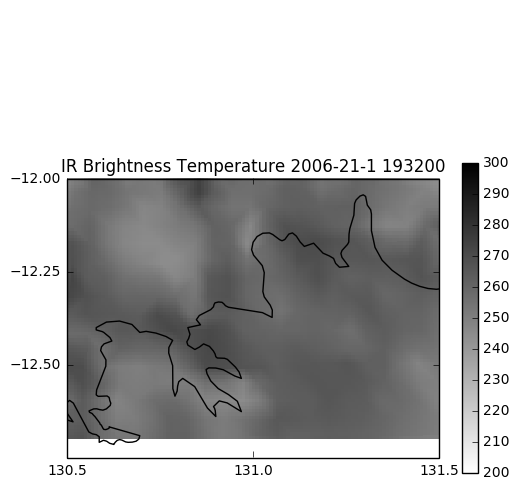

In [135]:
i = 2
cdf_data = Dataset(visst_image, mode='r')

# Load lat, lon, and time parameters - try statement for 24-hourly data, except for daily data

Latitude = cdf_data.variables['latitude']
Longitude = cdf_data.variables['longitude']
Time = cdf_data.variables['image_times']
NumPixels = cdf_data.variables['image_numpix']
year = 2006
day = 21
month = 1
# Load brightness temperature
IRBrightness = cdf_data.variables['temperature_ir']

frame = 27

j = frame

convective_regions = IRBrightness[:] < 240
Darwin_Lat = dms_to_decimal(-12, 25, 28.56)
Darwin_Lon = dms_to_decimal(130, 53, 29.75)

cpol_latitude = -12.249166
cpol_longitude = 131.04445

# Get Lat and Lon for specific frame
Lat = Latitude[(int(j)*int(NumPixels[j])):(int(j+1)*int(NumPixels[j])-1)]
Lon = Longitude[(int(j)*int(NumPixels[j])):(int(j+1)*int(NumPixels[j])-1)]


# Set up projection
plt.clf()
m = Basemap(width=500000, height=500000,
            resolution='l', projection='stere',
            lat_0=cpol_latitude,
            lon_0=cpol_longitude)

darwin_x, darwin_y = m(cpol_latitude, cpol_longitude)

# Regrid data to multidop's grid
x = pyart_grid.point_longitude['data'][0]
y = pyart_grid.point_latitude['data'][0]

index = j
data = IRBrightness[(int(j)*int(NumPixels[j])):(int(j+1)*int(NumPixels[j])-1)]
data_gridded = interpolate.griddata((Lon,Lat), data, (x,y))
lat_gridded = interpolate.griddata((Lon,Lat), Lat, (x,y))
lon_gridded = interpolate.griddata((Lon,Lat), Lon, (x,y))
lat_bounds = np.logical_or(lat_gridded > -12.75,
                           lat_gridded < -12)
lon_bounds = np.logical_or(lon_gridded < 130.5,
                           lon_gridded > 131.5)
masked_region = np.logical_or(lat_bounds, lon_bounds)
masked_region = np.logical_or(masked_region, data_gridded > 240)
data_masked = np.ma.array(data_gridded)
data_masked = np.ma.masked_where(masked_region, data_gridded)
print(lat_gridded)
# Plot the masked data
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
plt.pcolormesh(x,y,data_gridded, cmap='gray_r', vmin=190, vmax=270)
plt.text(Darwin_Lon, Darwin_Lat,
         'Darwin',
         fontweight='bold',
         color='white',
         )
plt.plot(Darwin_Lon, Darwin_Lat, 'w.')
ax.set_xticks([130, 130.5, 131, 131.5, 132], crs=ccrs.PlateCarree())
ax.set_yticks([-14, -13.5, -13, -12.5, -12.25,
               -12, -11,-10.5,], crs=ccrs.PlateCarree())
ax.set_xlim([130.5, 131.5])
ax.set_ylim([-12.75, -12])
plt.clim([200, 300])
plt.title('IR Brightness Temperature '
          + str(year)
          + '-'
          + str(day)
          + '-'
          + str(month)
          + ' '
          + seconds_to_midnight_to_string(Time[frame]))
plt.colorbar()

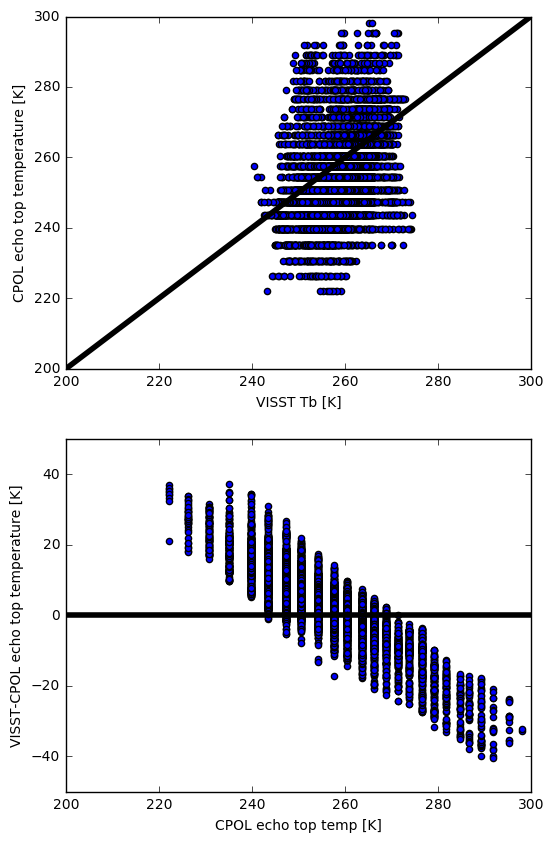

In [136]:
plt.figure(figsize=(6,10))
plt.subplot(211)
plt.scatter(data_gridded, echo_temp)
plt.plot([1, 300], [1, 300], linewidth=4, color='k')
plt.xlim([200, 300])
plt.ylim([200, 300])
plt.xlabel('VISST Tb [K]')
plt.ylabel('CPOL echo top temperature [K]')

plt.subplot(212)
plt.scatter(echo_temp, data_gridded-echo_temp)
plt.plot([200, 300], [0, 0], linewidth=4, color='k')
plt.xlim([200, 300])
plt.ylim([-50, 50])
plt.xlabel('CPOL echo top temp [K]')
plt.ylabel('VISST-CPOL echo top temperature [K]')